In [29]:
from utils import arg_parser, data_loader

import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (12, 8)

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self
        
def build_args(suffix="netsim",
               batch_size=128,
               datadir=os.path.join(os.getcwd(), "data")):
    
    args = AttrDict(suffix=suffix,
                    batch_size=batch_size,
                    datadir=datadir)
    
    args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if args.device.type != "cpu":
        if args.GPU_to_use is not None:
            torch.cuda.set_device(args.GPU_to_use)
        torch.cuda.manual_seed(args.seed)
        args.num_GPU = 1  # torch.cuda.device_count()
        args.batch_size_multiGPU = args.batch_size * args.num_GPU
    else:
        args.num_GPU = None
        args.batch_size_multiGPU = args.batch_size
        
    return args

## 1. NETSIM data

### Description

The Netsim data corresponds to a multivariate time series collected from $n=15$ brain regions of $S=5$ different human subjects. Each of the time series corresponds to $T=200$ observations of blood oxigenation level on the brain regions of the subject.

### Get data directly from the dataloader function

In [30]:
args = build_args(suffix="netsim",
                  batch_size=128,
                  datadir=os.path.join(os.getcwd(), "data"))

In [31]:
(
    train_loader,
    valid_loader,
    test_loader,
    loc_max,
    loc_min,
    vel_max,
    vel_min,
    
) = data_loader.load_data(args)

Loading data from /Users/danieloliveira/Documents/Daniel/codes/AmortizedCausalDiscovery/codebase/data
Loading data for subjects  [1, 2, 3, 4, 5]


In [32]:
train_loader

### Get data from the directory and trasnform it to a tensor

More information about tensor datasets can be found [here.](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [40]:
datadir = args.datadir

subject_id = [1, 2, 3, 4, 5] # subjects from who the brain data was collected

print("Loading data for subjects ", subject_id)

loc_train = torch.zeros(len(subject_id), 15, 200)
edges_train = torch.zeros(len(subject_id), 15, 15)

# load data for subject 1
elem = subject_id[0]
idx = 0

fileName = "sim3_subject_%s.npz" % (elem)
ld = np.load(os.path.join(datadir, "netsim", fileName))

# transform the data into tensor type data
loc_train[idx] = torch.FloatTensor(ld["X_np"])
edges_train[idx] = torch.LongTensor(ld["Gref"])

Loading data for subjects  [1, 2, 3, 4, 5]


In [34]:
ld.files

['X_np', 'Gref', 'n', 'T']

<AxesSubplot:>

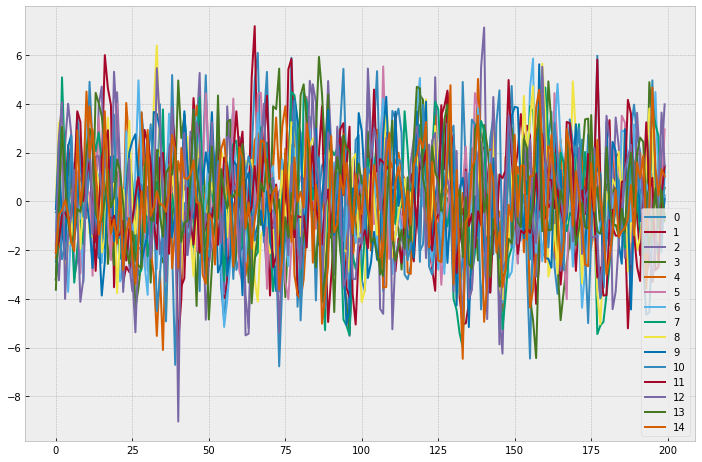

In [35]:
pd.DataFrame(ld["X_np"].T).plot()

In [36]:
ld["Gref"].T

array([[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int16)

In [42]:
loc_train

tensor([[[-2.4829, -0.5497, -0.9123,  ..., -1.3241, -1.8543,  0.2474],
         [-3.2105, -1.1406, -0.9786,  ...,  1.3088, -0.6535, -0.7120],
         [-1.7253, -3.2414, -0.6377,  ..., -0.9324,  1.6903,  3.9814],
         ...,
         [-1.9495,  2.6412,  4.0809,  ...,  0.4624,  3.6432,  1.4707],
         [-3.2103,  0.1267,  3.0497,  ..., -1.0985,  0.4498, -0.8144],
         [-2.1223, -0.5350, -0.3553,  ...,  0.2336,  1.3129,  1.0389]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0